## FFT demo of a real, periodic signal  
a) naive way  
b) windowing with DC treatment  


In [18]:
import io
from IPython.nbformat import read

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = read(f,3)
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
        
        
    
execute_notebook("create_plot_signal.ipynb")

from numpy import *
from numpy.fft import fft
from matplotlib.pyplot import *
%matplotlib inline

# redefine default figure size and fonts
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif',size=16)
mpl.rc('figure',figsize=(10,8))

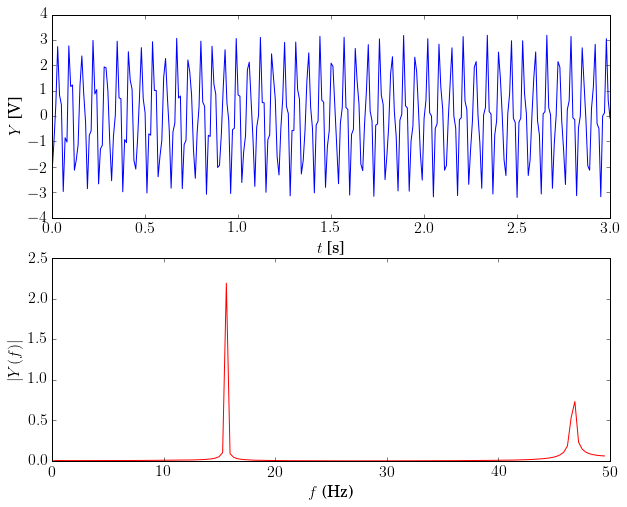

In [19]:
# Given:
f_s = 100.0 # sampling frequency (Hz)
T = 3.0 # total actual sample time (s)
from numpy import loadtxt
g = loadtxt('FFT_Example_data_with_window.txt')

del_t = 1/f_s   # time resolution [s]
t = arange(0.0,T+del_t,del_t)  # time, t (s)

plotSignal(t,g,f_s)

In [20]:
DC = g.mean()
print 'DC = %f [V]' % DC

DC = 0.452950 [V]


In [21]:
# Calculate
N = f_s*T           # number of data points
del_t = 1./f_s      # time resolution (s)
del_f = 1./T        # frequency resolution(Hz)
f_fold = f_s/2.     # folding frequency = Nyquist frequency of FFT (Hz)
N_freq = N/2.       # number of useful frequency points 

In [22]:
# Frequency
frequency = arange(0,f_fold,del_f)  #frequency (Hz)
G = fft(g) # FFT 
print G[:10]
print G.shape

[ 136.33790000+0.j            0.85689194+0.01756347j
    0.79560330+0.03999151j    0.83065943+0.02317239j
    0.81648114+0.01029308j    0.86012694-0.03048062j
    0.88366205-0.03279026j    0.91944369-0.03388283j
    0.82537342-0.0616697j     0.78619988+0.03823325j]
(301,)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


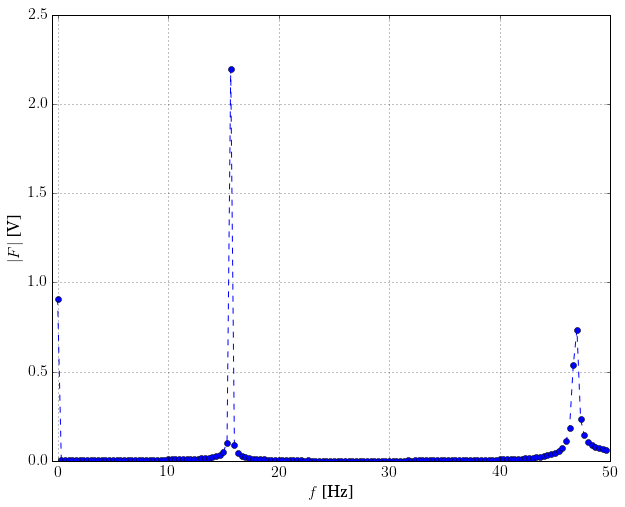

In [23]:
Magnitude = abs(G)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq],'--o')
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')

### Notes
1. Note the value at 0 Hz, what can we learn from it (we saw it's about 0.45 Volt? 
2. What do we take from here about frequencies? about 2.1V at 16 Hz and 0.7 Volt at 47 Hz? 
3. Let's remove DC and see the result

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


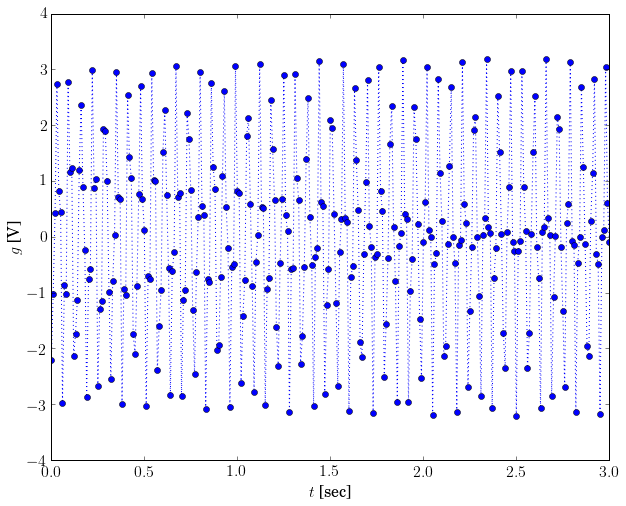

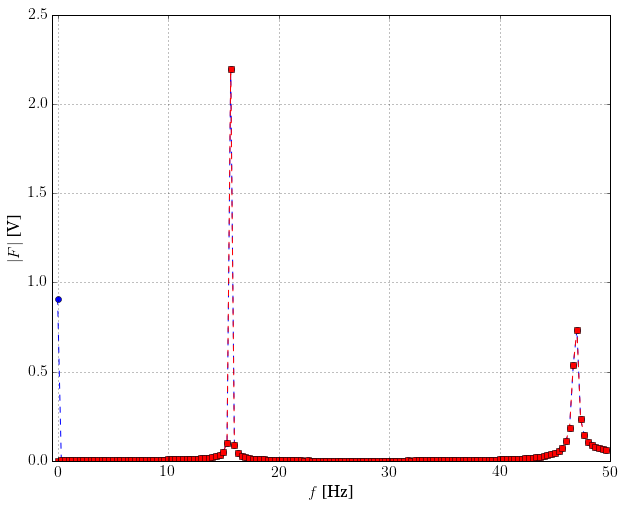

In [24]:
figure()
plot(t,g-DC,':o')
xlabel('$t$ [sec]')
ylabel('$g$ [V]')

G = fft(g-DC) # FFT of the signal without DC

Magnitude1 = abs(G)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq],'b--o', frequency,Magnitude1[:N_freq],'r--s')
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')

### Let's use do it the right way:
1. use 2^k number of points for faster FFT
2. multiply the signal by a low-pass filter:
    a. you assure there is no aliasing
    b. you get read of the edges and make it less leaking


In [25]:
# let's check how much we gain if we do it right size:
%timeit(fft(g)) 
%timeit(fft(g[:256]))  # 256 points instead of 301, not waisting much data


# even if it's longer, but the right size with zeros at the end
g1 = zeros((512,))
g1[:301] = g.copy()
%timeit(fft(g1))

The slowest run took 4.70 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 20.4 µs per loop
The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 8.45 µs per loop
The slowest run took 5.07 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13 µs per loop


In [26]:
# let's do it right:
N_2 = 2**fix(log2(N)).astype(int)        # shorten to 2^k
T_2 = N_2/f_s                             #  total useful sample time (s)
del_f_2 = 1/T_2                           # (Hz)
N_freq_2 = N_2/2                         # number of useful discrete frequencies
t_2 = arange(0.0,T_2+del_t,del_t)  #time, t (s)
frequency_2 = arange(0,f_fold,del_f_2)  #frequency (Hz)
len2, = t_2.shape

# remove DC first
g_uncoupled_2 = g - DC

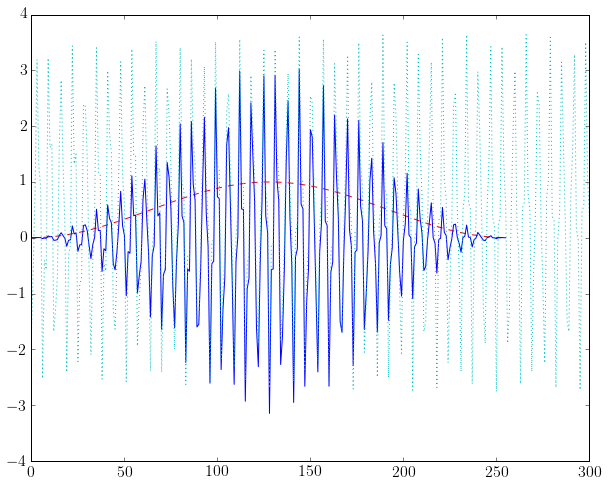

In [27]:
# create the low pass filter, called Hanning
u_Hann_2 = 0.5*(1-cos(2*pi*t_2[:-1]/T_2))  #u_Hanning(t)
DC_2 = mean(g[:len2-1])  #DC = mean value of input signal (V) (average of all the useful data)
g_uncoupled_2 = g[:len2-1]-DC_2  # uncoupled

g_Hann_2 = g_uncoupled_2 * u_Hann_2

figure()
plot(u_Hann_2,'r--')
plot(g_Hann_2,'b-')
plot(g,'c:')

In [28]:
# take the FFT of the filtered, shorter signal
G_Hann_2 = fft(g_Hann_2,N_2)  #G(omega) with Hanning window

Magnitude_Hann_2 = abs(G_Hann_2)*sqrt(8./3.)/(N_2/2)  #|F|*sqrt(8/3)/(N/2)
# Magnitude_Hann_2[0] = Magnitude_Hann_2[0]/2 + DC_2  #(also divide the first one by 2, and add back the DC value)

# len_loc, = Magnitude_Hann_2.shape
# A_2 = Magnitude_Hann_2[0:round(len_loc/2)]
# Freq_2 = frequency_2[0:round(len_loc/2)]

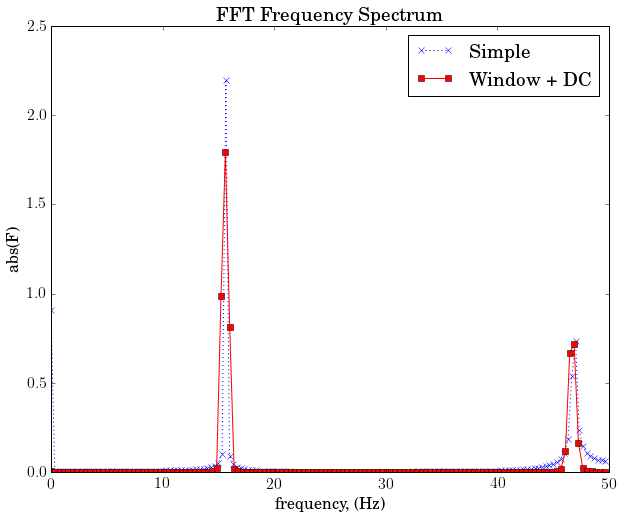

In [29]:

figure()
plot(frequency,Magnitude[:frequency.shape[0]],'b:x')
plot(frequency_2,Magnitude_Hann_2[:frequency_2.shape[0]], 'r-s')
xlabel('frequency, (Hz)')
ylabel('abs(F)')
title('FFT Frequency Spectrum')
legend(('Simple','Window + DC'))

In [30]:
# the frequency resolution is worse, but the result is better
del_f, del_f_2

(0.3333333333333333, 0.390625)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


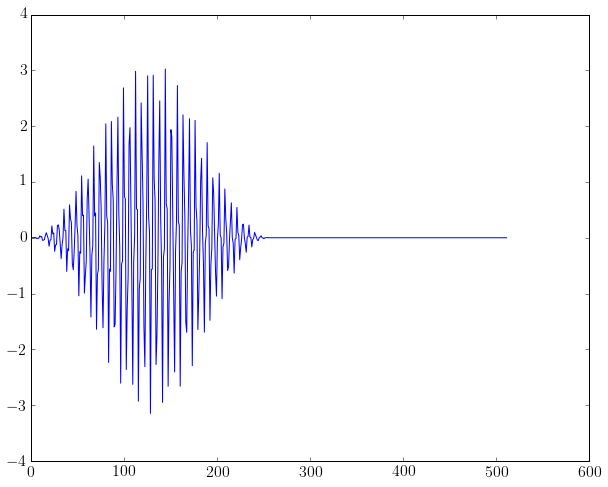

In [32]:
# let's do it better if we get more points, better resolution
# we can recover the same resolution as before by adding zeros
# or improve somewhat by taking longer to the next 2^k vector

N_3 = 2**ceil(log2(N)).astype(int)        # shorten to 2^k
T_3 = N_3/f_s                             #  total useful sample time (s)
del_f_3 = 1/T_3                           # (Hz)
N_freq_3 = N_3/2                         # number of useful discrete frequencies
t_3 = arange(0.0,T_3+del_t,del_t)  #time, t (s)
frequency_3 = arange(0,f_fold,del_f_3)  #frequency (Hz)
len3, = t_3.shape

# prepare the same signal
g_uncoupled_2 = g - DC
u_Hann_2 = 0.5*(1-cos(2*pi*t_2[:-1]/T_2))  #u_Hanning(t)
DC_2 = mean(g[:len2-1])  #DC = mean value of input signal (V) (average of all the useful data)
g_uncoupled_2 = g[:len2-1]-DC_2  # uncoupled
g_Hann_2 = g_uncoupled_2 * u_Hann_2


# pad with zeros
g_Hann_3 = zeros((N_3,))
g_Hann_3[:g_Hann_2.shape[0]] = g_Hann_2.copy() 

figure()
plot(g_Hann_3,'b-')

# take the FFT of the filtered, shorter signal
G_Hann_3 = fft(g_Hann_3,N_3)  #G(omega) with Hanning window

Magnitude_Hann_3 = abs(G_Hann_3)*sqrt(8./3.)/(N_2/2)  #|F|*sqrt(8/3)/(N/2)
# Magnitude_Hann_2[0] = Magnitude_Hann_2[0]/2 + DC_2  #(also divide the first one by 2, and add back the DC value)

len_loc, = Magnitude_Hann_3.shape
A_3 = Magnitude_Hann_3[0:round(len_loc/2)]
Freq_3 = frequency_3[0:round(len_loc/2)]

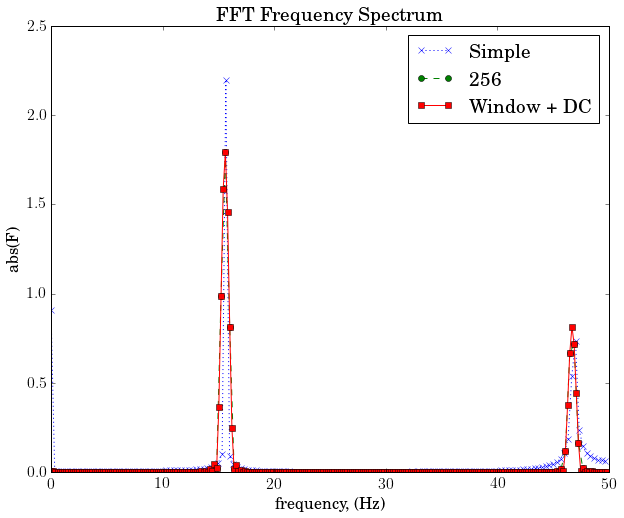

In [33]:
figure()
plot(frequency,Magnitude[:frequency.shape[0]],'b:x')
plot(frequency_2,Magnitude_Hann_2[:frequency_2.shape[0]], 'g--o')
xlabel('frequency, (Hz)')
plot(frequency_3,Magnitude_Hann_3[:frequency_3.shape[0]], 'r-s')
xlabel('frequency, (Hz)')
ylabel('abs(F)')
title('FFT Frequency Spectrum')
legend(('Simple','256', 'Window + DC'))

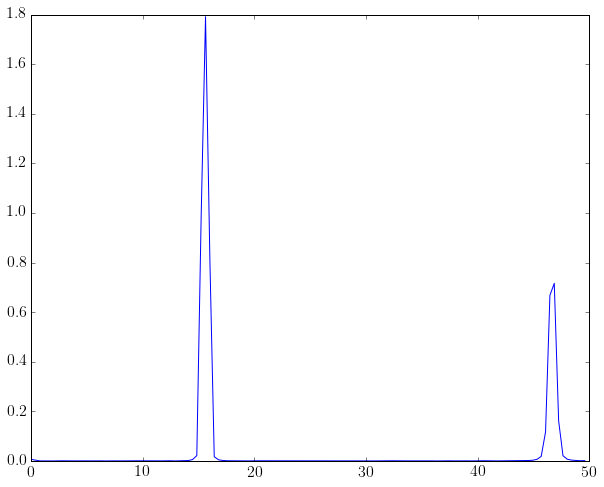

In [34]:
f = frequency_2
a = Magnitude_Hann_2[:f.shape[0]]
plot(f,a)

In [35]:
a1,f1 = a.max(),f[a.argmax()]
print a1,f1

1.79140154869 15.625


In [36]:
b = a.copy()
b[:a.argmax()+10] = 0 # remove the first peak
a2,f2 = b.max(),f[b.argmax()]
print a2,f2

0.71617392352 46.875


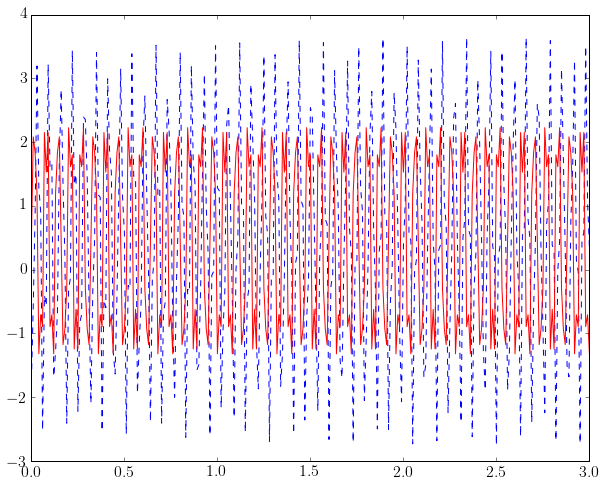

In [37]:
# our model now is the time reconstructed signal
t = arange(0.0,T+del_t,del_t)  # time, t (s)
g1 = DC + a1*sin(2*pi*f1*t) + a2*sin(2*pi*f2*t)
plot(t,g,'b--',t,g1,'r-')